# Adam vs. Alopex on MNIST in PyTorch

In [1]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 12)

In [2]:
import collections
import gzip
import itertools
import math
import random
import struct

import tqdm.notebook as tqdm
import munch

import matplotlib.pyplot as plt
import numpy as np

import skimage as ski

import torch as th

In [3]:
class MNIST(th.utils.data.Dataset):
    def __init__(self, partition='train'):
        super().__init__()
        
        self.images, self.labels = self._load_mnist(partition=partition)
        
    @staticmethod
    def _load_mnist(partition):
        if partition == 'train':
            file_prefix = 'train'
        elif partition == 'test':
            file_prefix = 't10k'
        else:
            raise ValueError(f'Invalid parition: {parition}')
    
        # thanks:
        # https://stackoverflow.com/questions/39969045/parsing-yann-lecuns-mnist-idx-file-format
        with gzip.open(f'../data/torchvision/MNIST/raw/{file_prefix}-images-idx3-ubyte.gz', mode='rb') as fh:
            _magic, size = struct.unpack('>II', fh.read(8))
            nrows, ncols = struct.unpack('>II', fh.read(8))
            data = np.frombuffer(fh.read(), dtype=np.dtype(np.uint8).newbyteorder('>')).copy()
            imgs = data.reshape((size, 1, nrows, ncols)) / 255.

        with gzip.open(f'../data/torchvision/MNIST/raw/{file_prefix}-labels-idx1-ubyte.gz', mode='rb') as fh:
            _magic, _size = struct.unpack('>II', fh.read(8))
            labels = np.frombuffer(fh.read(), dtype=np.dtype(np.uint8).newbyteorder('>')).copy()

        return th.as_tensor(imgs, dtype=th.float32), th.as_tensor(labels, dtype=th.int64)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]
    
    def __len__(self):
        return len(self.images)
    
    def plot_montage(self, n=36):
        #rng = random.Random(seed)
        #idxs = rng.sample(range(len(self)), n)
        idxs = range(n)
        
        imgs = np.moveaxis(self.images[idxs].numpy(), 1, -1)

        montage = ski.util.montage(imgs, channel_axis=-1)

        fig, ax = plt.subplots()
        ax.imshow(montage, cmap=plt.cm.gray)
        ax.axis('off')

In [4]:
train_data = MNIST(partition='train')
len(train_data)

60000

In [5]:
test_data = MNIST(partition='test')
len(test_data)

10000

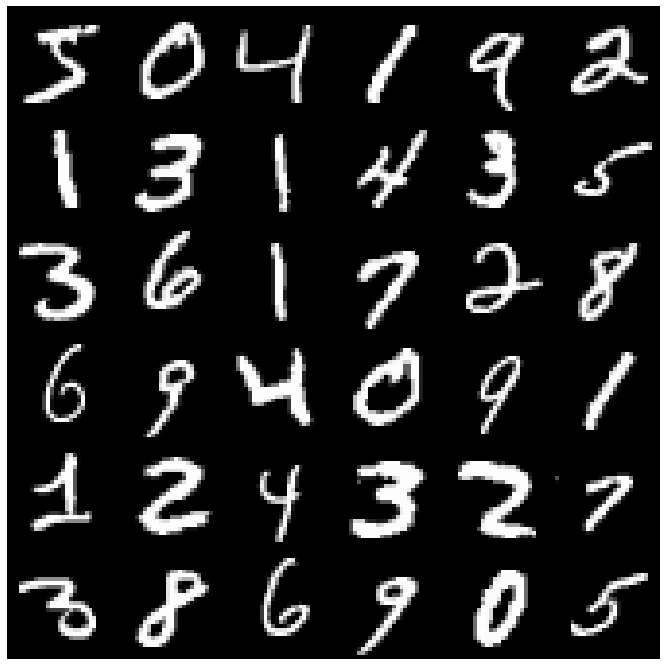

In [6]:
train_data.plot_montage()

In [7]:
image, label = train_data[0]
image.shape, label.shape

(torch.Size([1, 28, 28]), torch.Size([]))

In [8]:
train_data.images.mean(dim=(0, 2, 3)), train_data.images.std(dim=(0, 2, 3))

(tensor([0.1307]), tensor([0.3081]))

In [9]:
class _LREqualizer(th.nn.Module):
    def __init__(self, nonlinearity, alpha=None):
        super().__init__()
        self.nonlinearity = nonlinearity
        self.alpha = alpha

    def forward(self, w):
        fan_in, fan_out = th.nn.init._calculate_fan_in_and_fan_out(w)
        gain = th.nn.init.calculate_gain(
            nonlinearity=self.nonlinearity, param=self.alpha)

        return gain * w / math.sqrt(fan_in)

In [10]:
class _Conv2d(th.nn.Conv2d):
    def __init__(self, in_chans, out_chans, kernel_size, stride=1):
        super().__init__(
            in_chans, out_chans,
            kernel_size=kernel_size,
            stride=stride,
            padding=kernel_size // 2,
        )
        
        th.nn.utils.parametrize.register_parametrization(
            self, 'weight', _LREqualizer(nonlinearity='leaky_relu', alpha=1e-3))
        
    def reset_parameters(self):
        #th.nn.init.kaiming_normal_(self.weight, nonlinearity='relu')
        th.nn.init.normal_(self.weight)
        if getattr(self, 'bias', None) is not None:
            th.nn.init.zeros_(self.bias)

In [11]:
class _Linear(th.nn.Linear):
    def __init__(self, in_chans, out_chans, **kwargs):
        super().__init__(in_chans, out_chans, **kwargs)
        th.nn.utils.parametrize.register_parametrization(
            self, 'weight', _LREqualizer(nonlinearity='leaky_relu', alpha=1e-3))
        
    def reset_parameters(self):
        th.nn.init.normal_(self.weight)
        if getattr(self, 'bias', None) is not None:
            th.nn.init.zeros_(self.bias)
    
    #def reset_parameters(self):
    #    if not self.has_uninitialized_params() and self.in_features != 0:        
    #        #th.nn.init.kaiming_normal_(self.weight, nonlinearity='relu')
    #        th.nn.init.normal_(self.weight)
    #        if getattr(self, 'bias', None) is not None:
    #            th.nn.init.zeros_(self.bias)

In [12]:
_LayerSpec = collections.namedtuple(
    '_LayerSpec', ('num_filters', 'kernel_size', 'stride'), defaults=(2, 3))
_default_layer_specs = (
    ( 8, 3, 1),
    (16, 3, 2),
    (32, 3, 2),
    (64, 3, 2),
)

class CNN(th.nn.Module):
    def __init__(self, in_chans=1, img_size=28, num_classes=10, layer_specs=_default_layer_specs, num_dense=128,
                 means=[0.1307,], stdevs=[0.3081,]):
        super().__init__()
        
        layer_specs = list(itertools.starmap(_LayerSpec, layer_specs))
        
        self.register_buffer(
            'means', th.as_tensor(means).view(1, -1, 1, 1), persistent=False)
        self.register_buffer(
            'stdevs', th.as_tensor(stdevs).view(1, -1, 1, 1), persistent=False)
        
        small_img_size = img_size
        for layer_spec in layer_specs:
            small_img_size = math.ceil(small_img_size / layer_spec.stride)

        self.conv = th.nn.Sequential()
        layer_in, layer_out = None, in_chans
        for layer_spec in layer_specs:
            layer_in, layer_out = layer_out, layer_spec.num_filters
            num_filters, kernel_size, stride = layer_spec
            
            self.conv.append(
                th.nn.Sequential(
                    _Conv2d(
                        layer_in, layer_out,
                        kernel_size=kernel_size,
                        stride=stride),
                    #th.nn.SELU(inplace=True),
                    th.nn.LeakyReLU(inplace=True, negative_slope=1e-3),
                )
            )
            
        dense_dim = layer_out * small_img_size**2
        self.dense = th.nn.Sequential(
            th.nn.Flatten(),
            _Linear(dense_dim, num_dense),
            #_LazyLinear(num_dense),
            #th.nn.SELU(inplace=True),
            th.nn.LeakyReLU(inplace=True, negative_slope=1e-3),
            _Linear(num_dense, num_classes),
        )
        
    def forward(self, imgs):
        x = (imgs - self.means) / self.stdevs
        return self.dense(self.conv(x))
    
    @th.no_grad()
    def predict(self, imgs):
        logits = th.softmax(self(imgs), dim=1)
        return th.argmax(logits, dim=1)

In [13]:
model = CNN()
model

CNN(
  (conv): Sequential(
    (0): Sequential(
      (0): Parametrized_Conv2d(
        1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
            (0): _LREqualizer()
          )
        )
      )
      (1): LeakyReLU(negative_slope=0.001, inplace=True)
    )
    (1): Sequential(
      (0): Parametrized_Conv2d(
        8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
            (0): _LREqualizer()
          )
        )
      )
      (1): LeakyReLU(negative_slope=0.001, inplace=True)
    )
    (2): Sequential(
      (0): Parametrized_Conv2d(
        16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
            (0): _LREqualizer()
          )
        )
      )
      (1): LeakyReLU(negative_slope=0.001, inplace=True)
    )
 

In [14]:
with th.no_grad():
    preds = model(train_data.images[:32])
preds.shape, preds.mean(), preds.std()

(torch.Size([32, 10]), tensor(0.2726), tensor(0.7461))

In [15]:
print('free parameters:',
      sum(params.numel() for params in model.parameters() if params.requires_grad))

free parameters: 156874


## Training with Adam

In [16]:
def train_adam(model, data, epochs=30, batch_size=256, lr=0.001, lr_decay=0.98,
               device=0, num_workers=0):
    
    model.to(device)
    model.train()
    
    opt = th.optim.Adam(model.parameters(), lr=lr)
    sched = th.optim.lr_scheduler.ExponentialLR(opt, gamma=lr_decay)
    
    dataloader = th.utils.data.DataLoader(
        data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    
    losses = []

    for epoch in tqdm.trange(epochs, desc='epoch', leave=True):
        for images, labels in tqdm.tqdm(dataloader, desc='batch', leave=False):
            images = images.to(device=device, non_blocking=True)
            labels = labels.to(device=device, non_blocking=True)
            
            preds = model(images)
            loss = th.nn.functional.cross_entropy(preds, labels)
            losses.append(loss.item())

            opt.zero_grad()
            loss.backward()
            opt.step()
            
        sched.step()
        
    model.eval()
    model.cpu()
    
    return munch.Munch(
        losses=losses,
    )

In [17]:
adam_result = train_adam(model, train_data, epochs=30)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

batch:   0%|          | 0/234 [00:00<?, ?it/s]

batch:   0%|          | 0/234 [00:00<?, ?it/s]

batch:   0%|          | 0/234 [00:00<?, ?it/s]

batch:   0%|          | 0/234 [00:00<?, ?it/s]

batch:   0%|          | 0/234 [00:00<?, ?it/s]

batch:   0%|          | 0/234 [00:00<?, ?it/s]

batch:   0%|          | 0/234 [00:00<?, ?it/s]

batch:   0%|          | 0/234 [00:00<?, ?it/s]

batch:   0%|          | 0/234 [00:00<?, ?it/s]

batch:   0%|          | 0/234 [00:00<?, ?it/s]

batch:   0%|          | 0/234 [00:00<?, ?it/s]

batch:   0%|          | 0/234 [00:00<?, ?it/s]

batch:   0%|          | 0/234 [00:00<?, ?it/s]

batch:   0%|          | 0/234 [00:00<?, ?it/s]

batch:   0%|          | 0/234 [00:00<?, ?it/s]

batch:   0%|          | 0/234 [00:00<?, ?it/s]

batch:   0%|          | 0/234 [00:00<?, ?it/s]

batch:   0%|          | 0/234 [00:00<?, ?it/s]

batch:   0%|          | 0/234 [00:00<?, ?it/s]

batch:   0%|          | 0/234 [00:00<?, ?it/s]

batch:   0%|          | 0/234 [00:00<?, ?it/s]

batch:   0%|          | 0/234 [00:00<?, ?it/s]

batch:   0%|          | 0/234 [00:00<?, ?it/s]

batch:   0%|          | 0/234 [00:00<?, ?it/s]

batch:   0%|          | 0/234 [00:00<?, ?it/s]

batch:   0%|          | 0/234 [00:00<?, ?it/s]

batch:   0%|          | 0/234 [00:00<?, ?it/s]

batch:   0%|          | 0/234 [00:00<?, ?it/s]

batch:   0%|          | 0/234 [00:00<?, ?it/s]

batch:   0%|          | 0/234 [00:00<?, ?it/s]

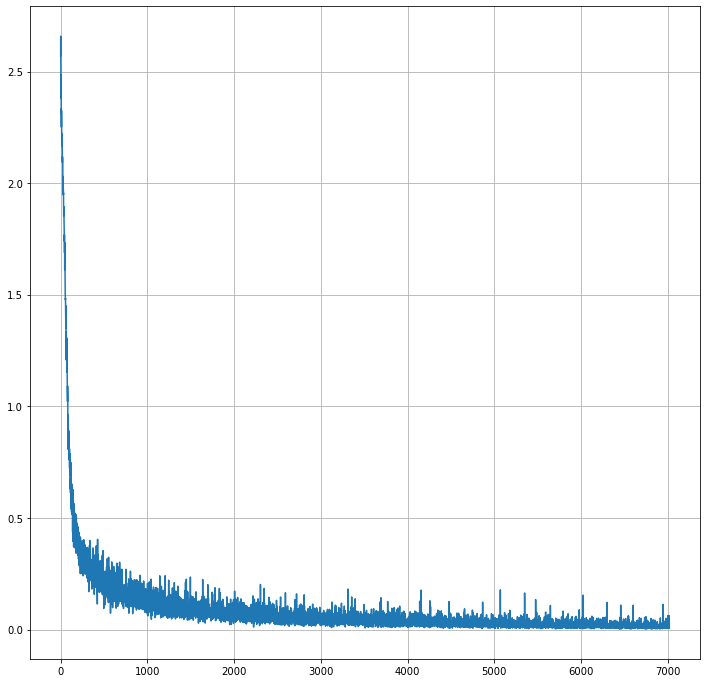

In [18]:
plt.plot(adam_result.losses);
plt.grid();

In [19]:
test_data.labels[:36].view(6, 6)

tensor([[7, 2, 1, 0, 4, 1],
        [4, 9, 5, 9, 0, 6],
        [9, 0, 1, 5, 9, 7],
        [3, 4, 9, 6, 6, 5],
        [4, 0, 7, 4, 0, 1],
        [3, 1, 3, 4, 7, 2]])

In [20]:
preds = model.predict(test_data.images)
preds[:36].view(6, 6)

tensor([[7, 2, 1, 0, 4, 1],
        [4, 9, 6, 9, 0, 6],
        [9, 0, 1, 5, 9, 7],
        [3, 4, 9, 6, 6, 5],
        [4, 0, 7, 4, 0, 1],
        [3, 1, 3, 4, 7, 2]])

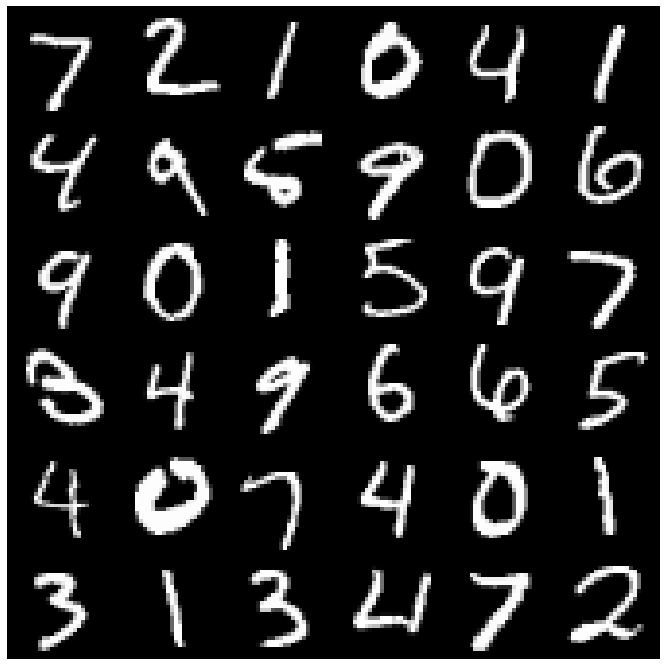

In [21]:
test_data.plot_montage(36)

In [22]:
def accuracy(y, g):
    return (y == g).to(th.float32).mean()

In [23]:
accuracy(preds, test_data.labels)

tensor(0.9830)

## Training with Alopex

In [24]:
class Alopex(th.optim.Optimizer):
    '''ALgorithm Of Pattern EXtraction (ALOPEX) 99/B version.
    '''
    def __init__(self, params, lr=5e-3, forget_factor=0.1, eps=1e-8):
        defaults = dict(
            lr=lr,
            forget_factor=forget_factor,
            eps=eps,
        )
        super().__init__(params, defaults)
        
    def _init_group(self, group, dws):
        for param in group['params']:
            state = self.state[param]

            # lazy state initialization
            first_step = False
            if len(state) <= 2:
                state['step'] = th.zeros((1,), dtype=th.float, device=param.device)
                state['dw'] = th.zeros_like(param)
                first_step = True

            dws.append(state['dw'])
            return first_step

    @th.no_grad()
    def step(self, closure):
        error = closure()

        first_state = self.state[self.param_groups[0]['params'][0]]
        if len(first_state) == 0:
            first_state['error'] = error
            first_state['mu'] = th.zeros((1,), dtype=th.float)

        de = error - first_state['error']
        first_state['error'] = error
        mu = first_state['mu']

        for group in self.param_groups:
            dws = []

            first_step = self._init_group(
                group=group,
                dws=dws,
            )
            
            if first_step:
                self._alopex_first_step(
                    params=group['params'],
                    lr=group['lr'],
                    dws=dws)
            else:
                self._alopex_step(
                    params=group['params'],
                    lr=group['lr'],
                    mu=mu,
                    dws=dws,
                    de=de,
                    forget_factor=group['forget_factor'],
                    eps=group['eps'],
            )

        return error
    
    @staticmethod
    def _alopex_first_step(params, lr, dws):
        for param, dw in zip(params, dws):
            draw = th.rand_like(param)
            dw[...] = th.where(draw < 0.5, -lr, lr)
            param.add_(dw)
    
    @staticmethod
    def _alopex_step(params, lr, mu, dws, de, forget_factor, eps):
        '''
        '''
        corrs = []
        corr_mag = th.zeros((1,), dtype=th.float)
        
        for param, dw in zip(params, dws):
            de = de.to(dw.device)
            corr = de * dw
            corrs.append(corr)
            corr_mag = corr_mag.to(param.device)
            corr_mag.add_(th.sum(corr.abs()))

        corr_mag.div_(sum(p.numel() for p in params))
        #corr_mag.div_(len(params))
        mu[...] = (1. - forget_factor) * mu + forget_factor * corr_mag.to(mu.device)
        mu.clamp_(eps)
        
        for param, corr, dw in zip(params, corrs, dws):
            mu = mu.to(device=param.device)
            
            prob = 1. / (1. + th.exp(-corr / mu))

            draw = th.rand_like(param)
            dw[...] = th.where(draw < prob, -lr, lr)
            param.add_(dw)

In [25]:
def train_alopex(model, data, epochs=30, batch_size=128, lr=0.001,
                 device=0, num_workers=0, **kwargs):
    
    model.to(device)
    model.train()
    
    opt = Alopex(model.parameters(), lr=lr, **kwargs)
    
    dataloader = th.utils.data.DataLoader(
        data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    
    losses = []
    mus = []

    for epoch in (pbar_epoch := tqdm.trange(epochs, desc='epoch', leave=True)):
        #for images, labels in (pbar_batch := tqdm.tqdm(dataloader, desc='batch', leave=False)):
        for images, labels in dataloader:
            images = images.to(device=device, non_blocking=True)
            labels = labels.to(device=device, non_blocking=True)
            
            def closure():
                preds = model(images)
                loss = th.nn.functional.cross_entropy(preds, labels, reduction='mean')
                losses.append(loss.item())
                return loss

            opt.step(closure)
            mus.append(opt.state[opt.param_groups[0]['params'][0]]['mu'].item())
            
            #pbar_batch.set_postfix({'loss': losses[-1]})
            
        num_batches = len(dataloader)
        pbar_epoch.set_postfix({'loss': sum(losses[-num_batches:]) / num_batches})
        
    model.eval()
    model.cpu()
    
    return munch.Munch(
        losses=losses,
        mus=mus,
    )

In [26]:
model = CNN(layer_specs=((8, 5, 2),),)
model

CNN(
  (conv): Sequential(
    (0): Sequential(
      (0): Parametrized_Conv2d(
        1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
            (0): _LREqualizer()
          )
        )
      )
      (1): LeakyReLU(negative_slope=0.001, inplace=True)
    )
  )
  (dense): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Parametrized_Linear(
      in_features=1568, out_features=128, bias=True
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _LREqualizer()
        )
      )
    )
    (2): LeakyReLU(negative_slope=0.001, inplace=True)
    (3): Parametrized_Linear(
      in_features=128, out_features=10, bias=True
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _LREqualizer()
        )
      )
    )
  )
)

In [27]:
alopex_result = train_alopex(model, train_data, batch_size=60_000, epochs=1_000, lr=0.001, forget_factor=0.1)

epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

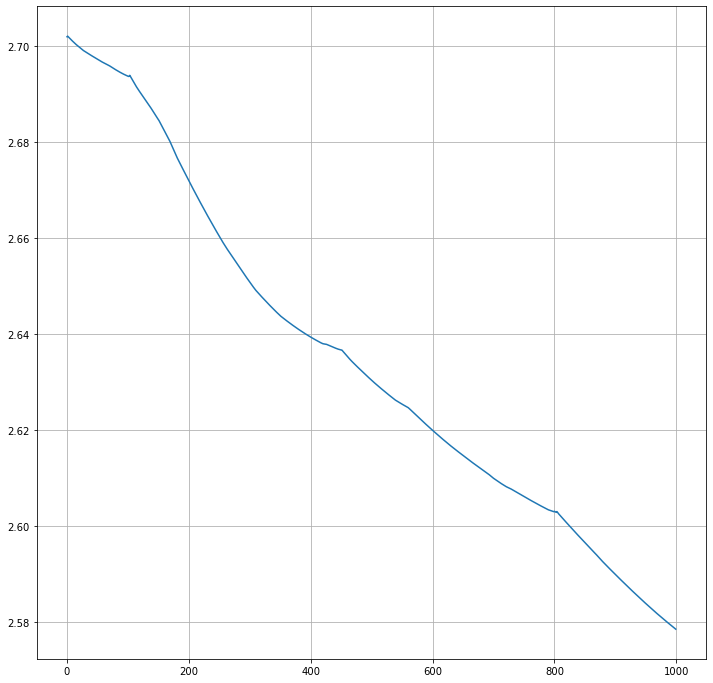

In [28]:
plt.plot(alopex_result.losses);
plt.grid();

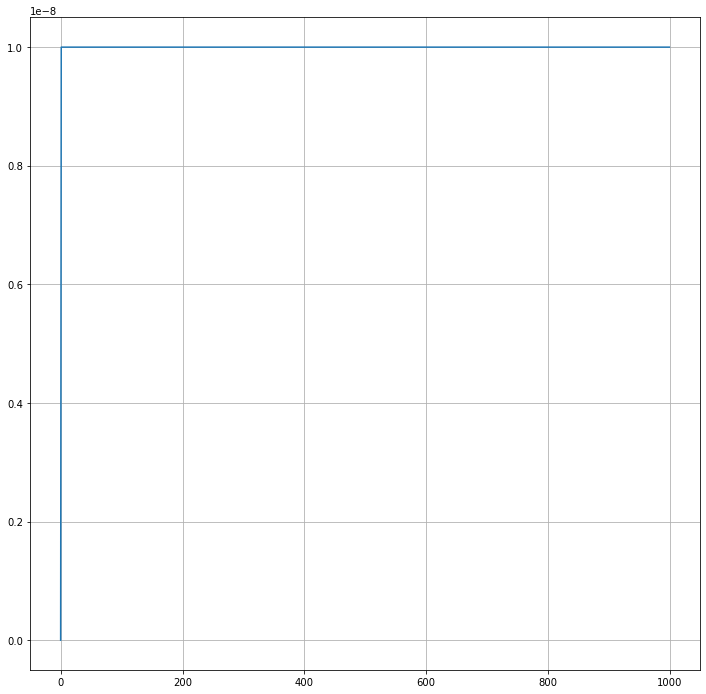

In [29]:
plt.plot(alopex_result.mus);
plt.grid();

In [30]:
test_data.labels[:36].view(6, 6)

tensor([[7, 2, 1, 0, 4, 1],
        [4, 9, 5, 9, 0, 6],
        [9, 0, 1, 5, 9, 7],
        [3, 4, 9, 6, 6, 5],
        [4, 0, 7, 4, 0, 1],
        [3, 1, 3, 4, 7, 2]])

In [31]:
preds = model.predict(test_data.images)
preds[:36].view(6, 6)

tensor([[0, 1, 5, 0, 4, 1],
        [2, 1, 4, 5, 5, 3],
        [1, 0, 1, 6, 3, 1],
        [5, 2, 5, 7, 2, 1],
        [6, 5, 6, 6, 0, 1],
        [1, 1, 7, 2, 5, 4]])

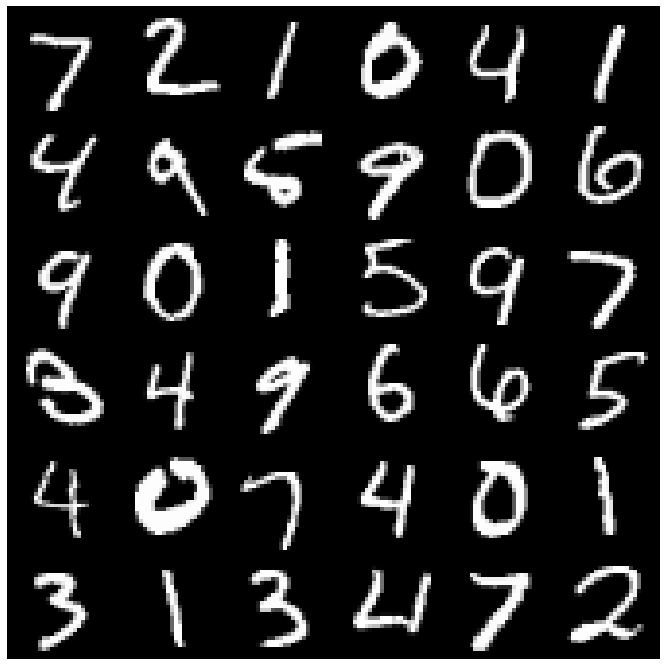

In [32]:
test_data.plot_montage(36)

In [33]:
accuracy(preds, test_data.labels)

tensor(0.1676)